# University of Liverpool - Ion Switching概要<br>URL：https://www.kaggle.com/c/liverpool-ion-switching<br><br>最終提出期限：2020/5/26

リバプール大学が主催するコンペです。<br>
生理学的電気データからイオンチャンネルが開いている数を予測します。<br><br>
コンペ期間中はテストデータの30%に対するスコアがPublic Leaderboardに掲載され、<br>
最終評価は残りの70%のテストデータに対するスコアでPrivate Leaderboardに順位付けされます。<br><br>
評価指標はマクロF1スコアです。<br>
参考：https://aiacademy.jp/texts/show/?id=34

# 訓練用データ（train.csv）
訓練用データは以下の構成となっています。
* データ数：5,000,000
* 説明変数：時間(time)、電気シグナル(signal)
* 目標変数：チャンネル開放数(open_channels)

In [1]:
import pandas as pd
train_data = pd.read_csv('../input/liverpool-ion-switching/train.csv')

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           float64
 1   signal         float64
 2   open_channels  int64  
dtypes: float64(2), int64(1)
memory usage: 114.4 MB


### 社内向けメモ
ここ最近開催されているKaggleのコンペとしては、説明変数がかなり少ない部類です。<br>
広義の意味でのセンサーデータのデータ分析と言えます。<br>
そのため、解法としては以下のような手法があげられます。
* GBDT系やNN系の機械学習を用いたクラス分類 or 回帰分析
* LSTMやCNN系の深層学習を用いたクラス分類 or 回帰分析

**本コンペの考え方は、工場でのセンサーデータの分析等にも転用できると思います。**

### データ補足
データ数は500万ですが、主催者から「50kHzの長さの10kHzサンプル」と情報開示がされています（5万個の時系列データが100サンプルある）<br>
また、人為的にセンサードリフトとノイズが加えられているようなので、データクリーニングが必要になります。<br>
* ドリフトデータについてのディスカッション：https://www.kaggle.com/c/liverpool-ion-switching/discussion/133874<br>
* ディスカッションの結果生成され共有されたデータ：https://www.kaggle.com/cdeotte/data-without-drift

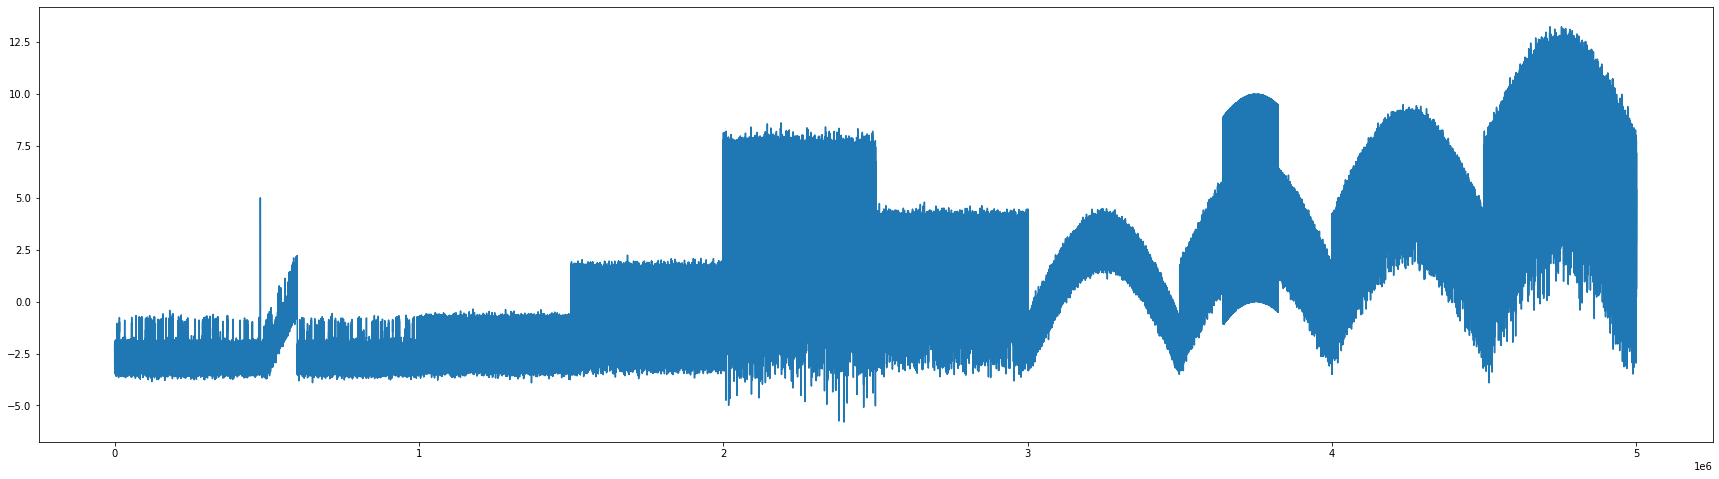

In [3]:
# オリジナルデータ
import matplotlib.pyplot as plt

plt.figure(figsize=(30,8))
train_data.signal.plot()

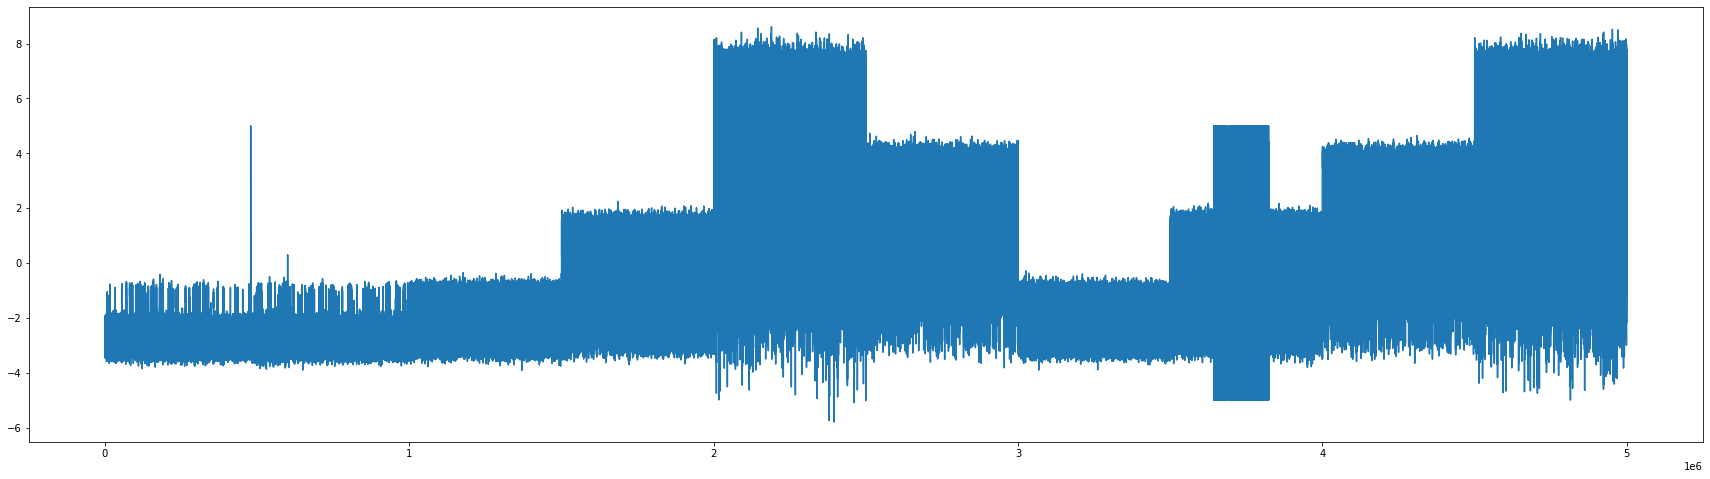

In [4]:
# クリーニング済みデータ
train_data = pd.read_csv('../input/data-without-drift/train_clean.csv')

plt.figure(figsize=(30,8))
train_data.signal.plot()

# EDA（探索的データ解析）
参加開始が遅かったため、自分でEDAは実施しておりません。<br>
公開ノートブックを参考にしています。
* https://www.kaggle.com/tarunpaparaju/ion-switching-competition-signal-eda

# 特徴量エンジニアリング
signalは時系列データとみなすことが出来るため、<br>セオリー的には以下のような特徴量を生成して追加することで予測精度の向上が期待できます。
* ウィンドウ幅に区切り統計量(最小値、最大値、平均、標準偏差、最小最大ギャップ、分位数、等)を追加
* ラグ特徴量を追加<br>参考：https://cpp-learning.com/preprocess-time-series/
* 勾配量を追加
* etc, etc...

In [5]:
# 各種インポート
import os
import random
import numpy as np

In [6]:
# 乱数シード初期化
def random_seed_initialize(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

random_seed_initialize()

In [7]:
# メモリ削減用関数
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
# インデックス整理
def set_index(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    return df

In [9]:
# バッチ処理用インデックス整理
def set_batch_index(df, batch_size1=50_000, batch_size2=5_000):
    df['batch'] = df.index // batch_size1
    df['batch_index'] = df.index - (df.batch * batch_size1)
    df['batch_slices'] = df['batch_index'] // batch_size2
    df['batch_slices2'] = df.apply(lambda r: '_'.join(
        [str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    return df

In [10]:
# 50000データ毎の統計量生成
def set_features_batch50000(df):
    df['signal_batch_min'] = df.groupby('batch')['signal'].transform('min')  # 最小値
    df['signal_batch_max'] = df.groupby('batch')['signal'].transform('max')  # 最大値
    df['signal_batch_std'] = df.groupby('batch')['signal'].transform('std')  # 標準偏差
    df['signal_batch_mean'] = df.groupby('batch')['signal'].transform('mean')  # 平均
    df['mean_abs_chg_batch'] = df.groupby(['batch'])['signal'].transform(lambda x: np.mean(np.abs(np.diff(x))))  # 前回との差分の平均
    df['abs_max_batch'] = df.groupby(['batch'])['signal'].transform(lambda x: np.max(np.abs(x)))  # 絶対値の最大値
    df['abs_min_batch'] =df.groupby(['batch'])['signal'].transform(lambda x: np.min(np.abs(x)))  # 絶対値の最小値

    df['range_batch'] = df['signal_batch_max'] - df['signal_batch_min']  # 最大値と最小値のギャップ
    df['maxtomin_batch'] = df['signal_batch_max'] / df['signal_batch_min']  # 最大値÷最小値
    df['abs_avg_batch'] = (df['abs_min_batch'] + df['abs_max_batch']) / 2  # 最大値（絶対値）と最小値（絶対値）の平均
    return df

In [11]:
# 5000データ毎の統計量生成
def set_features_batch5000(df):
    df['signal_batch_5k_min'] = df.groupby('batch_slices2')['signal'].transform('min')
    df['signal_batch_5k_max'] = df.groupby('batch_slices2')['signal'].transform('max')
    df['signal_batch_5k_std'] = df.groupby('batch_slices2')['signal'].transform('std')
    df['signal_batch_5k_mean'] = df.groupby('batch_slices2')['signal'].transform('mean')
    df['mean_abs_chg_batch_5k'] = df.groupby(['batch_slices2'])['signal'].transform(lambda x: np.mean(np.abs(np.diff(x))))
    df['abs_max_batch_5k'] = df.groupby(['batch_slices2'])['signal'].transform(lambda x: np.max(np.abs(x)))
    df['abs_min_batch_5k'] = df.groupby(['batch_slices2'])['signal'].transform(lambda x: np.min(np.abs(x)))

    df['range_batch_5k'] = df['signal_batch_5k_max'] - df['signal_batch_5k_min']
    df['maxtomin_batch_5k'] = df['signal_batch_5k_max'] / df['signal_batch_5k_min']
    df['abs_avg_batch_5k'] = (df['abs_min_batch_5k'] + df['abs_max_batch_5k']) / 2
    return df

In [12]:
# シフト参照によるラグ特徴量生成
def set_shift_features(df):
    df['signal_shift+1'] = df.groupby(['batch']).shift(1)['signal']
    df['signal_shift-1'] = df.groupby(['batch']).shift(-1)['signal']
    df['signal_shift+2'] = df.groupby(['batch']).shift(2)['signal']
    df['signal_shift-2'] = df.groupby(['batch']).shift(-2)['signal']
    return df

In [13]:
# 各特徴量のsignalとの差を特徴量として生成
def set_difference_features(df, ignore=['open_channels', 'time', 'batch', 'batch_index', 'batch_slices', 'batch_slices2',]):
    for c in list(set(df.columns) ^ set(ignore)):
        df[f'{c}_msignal'] = df[c] - df['signal']  
    return df

In [14]:
# 勾配特徴量生成
def set_gradients_features(df, n_grads=4):
    for i in range(n_grads):
        if i == 0:
            df['grad_' + str(i+1)] = df.groupby(['batch'])['signal'].transform(lambda x: np.gradient(x))
        else:
            df['grad_' + str(i+1)] = df.groupby(['batch'])['grad_' + str(i)].transform(lambda x: np.gradient(x))
    return df

In [15]:
# 特徴量生成
def set_features(df, is_test=False, memory_reduce=True):
    print('set_index()')
    df = set_index(df)
    print('set_batch_index()')
    df = set_batch_index(df)
    print('set_features_batch50000()')
    df = set_features_batch50000(df)
    print('set_features_batch5000()')
    df = set_features_batch5000(df)
    print('set_lag_features()')
    df = set_shift_features(df)
    print('set_gradients_features()')
    df = set_gradients_features(df)
    
    print('set_difference_features()')
    if not is_test:
        df = set_difference_features(df, ignore=['open_channels', 'time', 'batch', 'batch_index', 'batch_slices', 'batch_slices2'])
    else:
        df = set_difference_features(df, ignore=['time', 'batch', 'batch_index', 'batch_slices', 'batch_slices2'])
    
    df = df.fillna(0)
    
    if memory_reduce:
        print('reduce_mem_usage()')
        df = reduce_mem_usage(df)
    return df

In [16]:
# 学習用データに特徴量を付与
train_data = set_features(train_data)

# 表示確認
pd.set_option('display.max_columns', 200)
train_data.head(10)

set_index()
set_batch_index()
set_features_batch50000()
set_features_batch5000()
set_lag_features()
set_gradients_features()
set_difference_features()
reduce_mem_usage()
Mem. usage decreased to 672.34 Mb (72.9% reduction)


,time,signal,open_channels,batch,batch_index,batch_slices,batch_slices2,signal_batch_min,signal_batch_max,signal_batch_std,signal_batch_mean,mean_abs_chg_batch,abs_max_batch,abs_min_batch,range_batch,maxtomin_batch,abs_avg_batch,signal_batch_5k_min,signal_batch_5k_max,signal_batch_5k_std,signal_batch_5k_mean,mean_abs_chg_batch_5k,abs_max_batch_5k,abs_min_batch_5k,range_batch_5k,maxtomin_batch_5k,abs_avg_batch_5k,signal_shift+1,signal_shift-1,signal_shift+2,signal_shift-2,grad_1,grad_2,grad_3,grad_4,grad_3_msignal,abs_avg_batch_msignal,signal_batch_max_msignal,signal_batch_std_msignal,grad_2_msignal,maxtomin_batch_5k_msignal,grad_1_msignal,mean_abs_chg_batch_msignal,abs_min_batch_5k_msignal,range_batch_5k_msignal,signal_batch_5k_mean_msignal,signal_batch_5k_max_msignal,maxtomin_batch_msignal,mean_abs_chg_batch_5k_msignal,abs_max_batch_msignal,signal_shift-1_msignal,signal_batch_5k_std_msignal,signal_shift+2_msignal,signal_shift+1_msignal,grad_4_msignal,abs_max_batch_5k_msignal,signal_msignal,abs_avg_batch_5k_msignal,signal_batch_5k_min_msignal,signal_shift-2_msignal,abs_min_batch_msignal,signal_batch_min_msignal,range_batch_msignal,signal_batch_mean_msignal
0.0,0.0001,-2.759766,0,0.0,0.0,0.0,0.0_0.0,-3.662109,-0.765137,0.260742,-2.6875,0.270264,3.662109,0.765137,2.896484,0.208984,2.212891,-3.589844,-1.862305,0.24292,-2.695312,0.269775,3.589844,1.862305,1.726562,0.519043,2.726562,0.000000,-2.855469,0.000000,-2.408203,-0.095703,0.271973,-0.295410,0.022110,2.464844,4.972656,1.995117,3.021484,3.031250,3.279297,2.664062,3.031250,4.621094,4.488281,0.064392,0.897461,2.968750,3.029297,6.421875,-0.095703,3.003906,0.000000,0.000000,2.781250,6.347656,0.0,5.484375,-0.829590,0.352539,3.525391,-0.902344,5.656250,0.072815
1.0,0.0002,-2.855469,0,0.0,1.0,0.0,0.0_0.0,-3.662109,-0.765137,0.260742,-2.6875,0.270264,3.662109,0.765137,2.896484,0.208984,2.212891,-3.589844,-1.862305,0.24292,-2.695312,0.269775,3.589844,1.862305,1.726562,0.519043,2.726562,-2.759766,-2.408203,0.000000,-3.140625,0.176270,-0.023331,-0.273193,0.202393,2.582031,5.070312,2.089844,3.117188,2.832031,3.375000,3.031250,3.126953,4.718750,4.582031,0.160034,0.993164,3.064453,3.125000,6.519531,0.448242,3.099609,0.000000,0.095703,3.058594,6.445312,0.0,5.582031,-0.733887,-0.284668,3.621094,-0.806641,5.753906,0.168457
2.0,0.0003,-2.408203,0,0.0,2.0,0.0,0.0_0.0,-3.662109,-0.765137,0.260742,-2.6875,0.270264,3.662109,0.765137,2.896484,0.208984,2.212891,-3.589844,-1.862305,0.24292,-2.695312,0.269775,3.589844,1.862305,1.726562,0.519043,2.726562,-2.855469,-3.140625,-2.759766,-3.152344,-0.142334,-0.274414,0.109558,0.280029,2.517578,4.621094,1.642578,2.667969,2.132812,2.925781,2.265625,2.677734,4.269531,4.132812,-0.288330,0.544922,2.617188,2.677734,6.070312,-0.732910,2.650391,-0.352539,-0.448242,2.687500,5.996094,0.0,5.132812,-1.182617,-0.745117,3.171875,-1.254883,5.304688,-0.279785
3.0,0.0004,-3.140625,0,0.0,3.0,0.0,0.0_0.0,-3.662109,-0.765137,0.260742,-2.6875,0.270264,3.662109,0.765137,2.896484,0.208984,2.212891,-3.589844,-1.862305,0.24292,-2.695312,0.269775,3.589844,1.862305,1.726562,0.519043,2.726562,-2.408203,-3.152344,-2.855469,-2.642578,-0.372559,0.195801,0.287109,-0.131836,3.427734,5.355469,2.375000,3.400391,3.335938,3.660156,2.767578,3.410156,5.003906,4.867188,0.444824,1.277344,3.349609,3.410156,6.800781,-0.012100,3.382812,0.284668,0.732910,3.007812,6.730469,0.0,5.867188,-0.449219,0.498535,3.906250,-0.521484,6.039062,0.453125
4.0,0.0005,-3.152344,0,0.0,4.0,0.0,0.0_0.0,-3.662109,-0.765137,0.260742,-2.6875,0.270264,3.662109,0.765137,2.896484,0.208984,2.212891,-3.589844,-1.862305,0.24292,-2.695312,0.269775,3.589844,1.862305,1.726562,0.519043,2.726562,-3.140625,-2.642578,-2.408203,-2.699219,0.249268,0.299561,-0.154175,-0.244751,2.998047,5.367188,2.386719,3.414062,3.451172,3.671875,3.402344,3.421875,5.015625,4.878906,0.456787,1.290039,3.361328,3.421875,6.816406,0.510742,3.394531,0.745117,0.012100,2.908203,6.742188,0.0,5.878906,-0.437012,0.453125,3.917969,-0.509766,6.050781,0.465332
5.0,0.000

# 学習
いったん例としてLGBMでの学習結果を記載しています。<br>
※LGBM(Light GBM：軽量化勾配ブースティングモデル)は学習が早く、後述のSHAPでの重要特徴量の分析ができることから、<br>
　初手で試されることが多いモデルです。<br><br>
また、LGBM自体の精度が良いため、LGBMで精度を高め、LGBMと相性の良いモデル(ランダムフォレスト、ニューラルネットワーク、Ridge、LASSO等)とアンサンブルして精度を高めるという手法も良くとられます。

In [17]:
from pycaret.regression import *

#### 社内向けメモ
このノートブックではPyCaretと言う機械学習ツールを利用していますが、<br>個人的な所感としてPyCaretは悪い意味で中級車向け（抽象化されすぎている箇所があり、用語を知らない初級者に向かず、現行verでは拡張性が高くなく上級者にも向かない）なので、狙いがあって使う場合以外はscikit-learnをおススメします。

In [18]:
# 学習時に無視するカラム
IGNORE_FEATURES  = [
                    'time',
                    'batch',
                    'batch_index',
                    'batch_slices',
                    'batch_slices2'
                   ]

print('TARGET FEATURE LIST : ', end="")
print([f for f in list(set(IGNORE_FEATURES) ^ set(train_data.columns))])

TARGET FEATURE LIST : ['maxtomin_batch_5k_msignal', 'open_channels', 'abs_avg_batch', 'maxtomin_batch_msignal', 'signal_batch_max', 'mean_abs_chg_batch_msignal', 'signal_batch_std', 'abs_avg_batch_5k_msignal', 'grad_2', 'grad_1', 'range_batch_5k', 'signal_batch_std_msignal', 'signal_batch_mean_msignal', 'signal_batch_5k_mean_msignal', 'signal_shift+1_msignal', 'abs_max_batch', 'signal_batch_5k_min_msignal', 'grad_3_msignal', 'signal_shift-1', 'abs_min_batch_msignal', 'grad_4_msignal', 'signal_shift+1', 'mean_abs_chg_batch_5k_msignal', 'signal', 'abs_avg_batch_5k', 'signal_batch_5k_min', 'signal_batch_5k_std_msignal', 'signal_shift-2', 'abs_min_batch', 'signal_batch_min', 'signal_shift-1_msignal', 'signal_batch_max_msignal', 'abs_avg_batch_msignal', 'grad_3', 'maxtomin_batch_5k', 'mean_abs_chg_batch', 'signal_shift+2_msignal', 'signal_batch_5k_max_msignal', 'abs_min_batch_5k', 'abs_max_batch_msignal', 'range_batch_5k_msignal', 'signal_batch_min_msignal', 'signal_batch_5k_mean', 'signal_

In [19]:
exp = setup(data = train_data, 
            target = 'open_channels',
            silent=True,
            sampling = False,
            ignore_features = IGNORE_FEATURES,
            session_id=42)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(5000000, 64)"
4,Missing Values,False
5,Numeric Features,62
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [20]:
# 交差検証数10でLGBMを訓練
lgbm_model = create_model('lightgbm', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0542,0.0259,0.1609,0.9964,0.0398,0.0184
1,0.0538,0.0260,0.1612,0.9963,0.0401,0.0184
2,0.0538,0.0258,0.1607,0.9964,0.0403,0.0184
3,0.0541,0.0259,0.1609,0.9964,0.0395,0.0182
4,0.0537,0.0258,0.1605,0.9964,0.0400,0.0184
5,0.0537,0.0256,0.1599,0.9964,0.0395,0.0182
6,0.0537,0.0257,0.1603,0.9964,0.0401,0.0184
7,0.0544,0.0264,0.1624,0.9963,0.0400,0.0184
8,0.0539,0.0258,0.1605,0.9964,0.0398,0.0183
9,0.0538,0.0259,0.1608,0.9963,0.0392,0.0182


In [21]:
lgbm_model = finalize_model(lgbm_model)

# モデル解釈（SHAP法）
参考：https://qiita.com/shin_mura/items/cde01198552eda9146b7

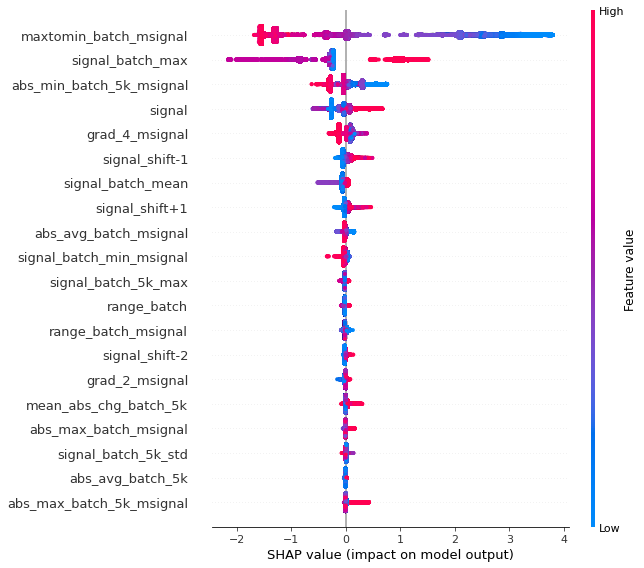

In [22]:
interpret_model(lgbm_model)

# 推論

In [23]:
# テストデータ読み込み
test_data  = pd.read_csv('../input/data-without-drift/test_clean.csv')
test_data = set_features(test_data, is_test=True)
pd.set_option('display.max_columns', 200)
test_data.head()

set_index()
set_batch_index()
set_features_batch50000()
set_features_batch5000()
set_lag_features()
set_gradients_features()
set_difference_features()
reduce_mem_usage()
Mem. usage decreased to 267.03 Mb (72.7% reduction)


,time,signal,batch,batch_index,batch_slices,batch_slices2,signal_batch_min,signal_batch_max,signal_batch_std,signal_batch_mean,mean_abs_chg_batch,abs_max_batch,abs_min_batch,range_batch,maxtomin_batch,abs_avg_batch,signal_batch_5k_min,signal_batch_5k_max,signal_batch_5k_std,signal_batch_5k_mean,mean_abs_chg_batch_5k,abs_max_batch_5k,abs_min_batch_5k,range_batch_5k,maxtomin_batch_5k,abs_avg_batch_5k,signal_shift+1,signal_shift-1,signal_shift+2,signal_shift-2,grad_1,grad_2,grad_3,grad_4,grad_3_msignal,signal_batch_5k_mean_msignal,signal_batch_5k_max_msignal,maxtomin_batch_msignal,mean_abs_chg_batch_5k_msignal,abs_avg_batch_msignal,abs_max_batch_msignal,signal_batch_max_msignal,signal_shift-1_msignal,signal_batch_std_msignal,signal_batch_5k_std_msignal,signal_shift+2_msignal,grad_2_msignal,signal_shift+1_msignal,maxtomin_batch_5k_msignal,grad_4_msignal,grad_1_msignal,abs_max_batch_5k_msignal,signal_msignal,abs_avg_batch_5k_msignal,mean_abs_chg_batch_msignal,abs_min_batch_5k_msignal,range_batch_5k_msignal,signal_batch_5k_min_msignal,signal_shift-2_msignal,abs_min_batch_msignal,signal_batch_min_msignal,range_batch_msignal,signal_batch_mean_msignal
5000000.0,500.0,-2.650391,100.0,0.0,0.0,100.0_0.0,-3.818359,-0.614746,0.361328,-2.630859,0.28418,3.818359,0.614746,3.203125,0.161011,2.216797,-3.539062,-1.842773,0.244873,-2.695312,0.270752,3.539062,1.842773,1.695312,0.520508,2.689453,0.000000,-2.849609,0.000000,-2.859375,-0.199585,0.094482,0.108887,-0.099304,2.757812,-0.045319,0.807129,2.810547,2.919922,4.867188,6.468750,2.035156,-0.199585,3.011719,2.894531,0.000000,2.744141,0.000000,3.169922,2.550781,2.451172,6.187500,0.0,5.339844,2.933594,4.492188,4.343750,-0.888184,-0.210205,3.265625,-1.167969,5.851562,0.018158
5000001.0,500.0,-2.849609,100.0,1.0,0.0,100.0_0.0,-3.818359,-0.614746,0.361328,-2.630859,0.28418,3.818359,0.614746,3.203125,0.161011,2.216797,-3.539062,-1.842773,0.244873,-2.695312,0.270752,3.539062,1.842773,1.695312,0.520508,2.689453,-2.650391,-2.859375,0.000000,-2.435547,-0.105103,0.203369,0.009590,-0.139404,2.859375,0.154297,1.006836,3.009766,3.121094,5.066406,6.667969,2.234375,-0.010628,3.210938,3.093750,0.000000,3.052734,0.199585,3.371094,2.710938,2.744141,6.386719,0.0,5.539062,3.132812,4.691406,4.546875,-0.688965,0.414307,3.464844,-0.968262,6.050781,0.217773
5000002.0,500.0,-2.859375,100.0,2.0,0.0,100.0_0.0,-3.818359,-0.614746,0.361328,-2.630859,0.28418,3.818359,0.614746,3.203125,0.161011,2.216797,-3.539062,-1.842773,0.244873,-2.695312,0.270752,3.539062,1.842773,1.695312,0.520508,2.689453,-2.849609,-2.435547,-2.650391,-2.615234,0.207153,0.113647,-0.169922,-0.056152,2.689453,0.164917,1.017578,3.021484,3.130859,5.078125,6.675781,2.246094,0.425049,3.220703,3.105469,0.210205,2.974609,0.010628,3.380859,2.804688,3.066406,6.398438,0.0,5.550781,3.144531,4.703125,4.554688,-0.678223,0.244385,3.474609,-0.957520,6.062500,0.228394
5000003.0,500.0,-2.435547,100.0,3.0,0.0,100.0_0.0,-3.818359,-0.614746,0.361328,-2.630859,0.28418,3.818359,0.614746,3.203125,0.161011,2.216797,-3.539062,-1.842773,0.244873,-2.695312,0.270752,3.539062,1.842773,1.695312,0.520508,2.689453,-2.859375,-2.615234,-2.849609,-2.566406,0.122192,-0.136353,-0.102661,0.113892,2.332031,-0.260010,0.592773,2.595703,2.705078,4.652344,6.253906,1.820312,-0.180542,2.796875,2.679688,-0.414307,2.298828,-0.425049,2.955078,2.548828,2.556641,5.972656,0.0,5.125000,2.718750,4.277344,4.128906,-1.103516,-0.130981,3.050781,-1.382812,5.636719,-0.196533
5000004.0,500.0,-2.615234,100.0,4.0,0.0,100.0_0.0,-3.818359,-0.614746,0.361328,-2.630859,0.28418,3.818359,0.614746,3.203125,0.161011,2.216797,-3.539062,-1.842773,0.244873,-2.695312,0.270752,3.539062,1.842773,1.695312,0.520508,2.689453,-2.435547,-2.566406,-2.859375,-2.738281,-0.065491,-0.091675,0.057922,0.075012,2.673828,-0.079468,0.772949,2.777344,2.886719,4.832031,6.433594,2.000000,0.049561,2.976562,2.861328,-0.244385,2.523438,0.180542,3.136719,2.691406,2.550781,6.152344,0.0,5.304688,2.900391,4.457031,4.312500,-0.922363,-0.122375,3.230469,-1

In [24]:
# 推論実施
predictions = predict_model(lgbm_model, data=test_data)
predictions['open_channels'] = predictions['Label']

In [25]:
# 提出用データ作成
sub = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv")

submission = pd.DataFrame()
submission['time']  = sub['time']
submission['open_channels'] = predictions['open_channels']
submission['open_channels'] = submission['open_channels'].round(decimals=0)
submission['open_channels'] = submission['open_channels'].astype(int)
submission.to_csv('submission.csv', float_format='%0.4f', index = False)

ちなみに上記のデータを提出すると2020/5/24時点で以下の順位です。
* Public Leaderboard スコア：0.937<br>スコアの範囲は1.0～0.0で1に近いほど高いスコアです。<br>2020/5/24時点での最高スコアは0.947です。
* 1,573位/2,594チーム(上位60.6%)

Kaggleの個人的なイメージですが、ひとまず、セオリー通りの実装をして上位50%～60%くらいの順位のイメージです。

# 【整理中】精度向上方法メモ

* カルマンフィルターを適用
* 特徴量を追加<br>・ローパスフィルター適用<br>・加重移動平均適用<br>・窓幅のバリエーションを追加
* アンサンブル学習<br>・バギング<br>・ブースティング ※LGBM自体がブースティング系のため効果薄<br>・ブレンディング<br>・スタッキング
* ランダムシードアベレージ
* Submissionアンサンブル
* Linear Quiz Blending
* 遺伝的アルゴリズムによる特徴量生成